### Imports

In [1]:
import pandas as pd
import reciprocalspaceship as rs
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import r2_score
import numpy as np
import json
from scipy import stats
import random
import math
import gemmi
from sklearn.decomposition import PCA
import time
import sys
from scipy.stats import pearsonr
import pickle
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

2022-11-11 08:22:31.532196: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras

### Ligand CIF Processing

In [3]:
ligand_cif = []

with open('../PTP1B_DK/ligand_cif_to_dataset_mapping.txt') as f:
    lines = f.readlines()
    
for line in lines:
    dataset, ligands = line[:-1].split(":")
    ligands = list(filter(None,ligands.split(" ")))
    ligand_cif.append([dataset, ligands, 0 if len(ligands) > 0 else 1])
    
ligand_cif = pd.DataFrame(ligand_cif, columns=["Dataset", "Ligands", "Apo"])

apo_samples = ligand_cif[ligand_cif['Apo'] == 1]['Dataset'].tolist()
apo_samples = [sample.split('y')[1] for sample in apo_samples]

samples = ligand_cif['Dataset'].tolist()
samples = [sample.split('y')[1] for sample in samples]

### VAE

In [4]:
def model_to_dict(model):
    '''
    Convert a tf.keras.Model to a dictonary for further save

    Parameters
    ----------
    model: Instance of tf.keras.Model object, with input_shape

    Returns
    -------
    A dictionary

    '''
    d = {'config' : model.get_config(),
         'input_shape' : model.input_shape,
         'weights' : model.get_weights()}
    return d

def model_from_dict(d, custom_objects=None):
    '''
    Construct a tf.keras.Model from a dictonary, with possible custom object

    Parameters
    ----------
    d: the dictionary generated by model_to_dict

    custom_objects: specify the customized layer type in your model config, see https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object 

    Returns
    -------
    A tf.keras.Model object 
    '''
    model = tf.keras.Model.from_config(d['config'], custom_objects=custom_objects)
    model.build(d['input_shape'])
    model.set_weights(d['weights'])

    return model

In [5]:
class Sampling(tf.keras.layers.Layer):
    """
    Reparameterization Trick
    Uses (z_mean, z_log_var) to sample z, with normal distribution.
    """
    
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def make_encoder(input_dim, latent_dim, n_hidden_layers, list_of_hidden_units, activation):
    
    '''
    Construct a keras model as encoder, which mapping the input x into mean, log_var and samples in latent space with dense layers
    '''
    
    assert n_hidden_layers == len(list_of_hidden_units), "Make sure the list of hidden units has same length as the number of layers!"
    
    Inputs = tf.keras.Input(shape=(input_dim,))
    
    # Hidden layers
    for i, n_units in enumerate(list_of_hidden_units):
        if i == 0:
            x = tf.keras.layers.Dense(n_units, activation=activation)(Inputs)
        else:
            x = tf.keras.layers.Dense(n_units, activation=activation)(x)
    
    # The variational output player
    output_mean = tf.keras.layers.Dense(latent_dim, activation=None)(x)
    output_log_var = tf.keras.layers.Dense(latent_dim, activation=None)(x)
    output = Sampling()([output_mean, output_log_var])
    
    model = tf.keras.Model(Inputs, [output_mean, output_log_var, output], name="encoder")
    
    return model

def make_decoder(input_dim, output_dim, n_hidden_layers, list_of_hidden_units, activation):
    
    '''
    Return a keras model, which decode the input z into output x with dense layers
    '''
    
    assert n_hidden_layers == len(list_of_hidden_units), "Make sure the list of hidden units has same length as the number of layers!"
    
    Inputs = tf.keras.Input(shape=(input_dim,))
    
    # Hidden layers
    for i, n_units in enumerate(list_of_hidden_units):
        if i == 0:
            x = tf.keras.layers.Dense(n_units, activation=activation)(Inputs)
        else:
            x = tf.keras.layers.Dense(n_units, activation=activation)(x)
    
    output = tf.keras.layers.Dense(output_dim, activation=None)(x)
    
    model = tf.keras.Model(Inputs, output, name="decoder")
    
    return model

In [6]:
class VAE(tf.keras.models.Model):
    
    '''
    Initialize a VAE model with assigned parameters

    Parameters:
    -----------
    n_dim_io: int
        Number of input and output dimensionality
    
    n_dim_latent: int, default 1
        Number of dimensionality in latent space

    n_hidden_layers: int, or [int, int]
        Number of hidden layers in the encoder and decoder. If an int is given, it will applied to both encoder and decoder;
        If a length 2 list is given, first int will be used for encoder, the second will be used for decoder

    n_hidden_size: int, or [int, int], or array of int
        Number of units in hidden layers. If an int is given, i will be applied to all hidden layers in both encoder and decoder;
        If a length 2 array is given, first int will be used for all layers in the encoder, the second will be used for the decoder.
        Or an array with length equal to the number of hidden layers can be given, the number of units will be assigned accordingly.

    activation: str, default tanh
        activation function for the hidden layers
    '''
    
    def __init__(self, n_dim_i, n_dim_o, n_dim_latent=1, n_hidden_layers=3, n_hidden_size=100, activation='tanh'):     
        
        super(VAE, self).__init__()
        
        if type(n_hidden_layers) is int:
            self.n_layer_encoder = n_hidden_layers
            self.n_layer_decoder = n_hidden_layers
        elif len(n_hidden_layers) == 2:
            self.n_layer_encoder = n_hidden_layers[0]
            self.n_layer_decoder = n_hidden_layers[1]
        else:
            raise ValueError("Please provide legal n_hidden_layers!")
        
        # List of hidden units in encoder and decoder
        if type(n_hidden_size) is int:
            self.n_size_encoder = [n_hidden_size]*self.n_layer_encoder
            self.n_size_decoder = [n_hidden_size]*self.n_layer_decoder
        elif len(n_hidden_size) == 2:
            self.n_size_encoder = [n_hidden_size[0]]*self.n_layer_encoder
            self.n_size_decoder = [n_hidden_size[1]]*self.n_layer_decoder
        elif len(n_hidden_size) == self.n_layer_encoder+self.n_layer_decoder:
            self.n_size_encoder = n_hidden_size[:self.n_layer_encoder]
            self.n_size_decoder = n_hidden_size[self.n_layer_encoder:]
        else: 
            raise ValueError("Pleas provide legal n_hidden_size!")
        
        self.dim_x = n_dim_i
        self.dim_y = n_dim_o
        self.activation = activation
        self.dim_z = n_dim_latent
        
        self.encoder = make_encoder(self.dim_x, self.dim_z, self.n_layer_encoder, self.n_size_encoder, self.activation)
        self.decoder = make_decoder(self.dim_z, self.dim_y, self.n_layer_decoder, self.n_size_decoder, self.activation)
        
        self.loss_train = []
        self.loss_names = ["Loss", "NLL", "KL_div", "Mean_LS"]
        
    def sample(self, n_sample=1000, mu=0, sigma=1):
        z = tf.random.normal([n_sample, self.dim_z], mean=mu, stddev=sigma)
        x = self.decoder(z)
        return x

    def reconstruct(self, input_x):
        z_mean, z_log_var, z = self.encoder(input_x)
        recons = self.decoder(z)
        return recons
        
    @classmethod
    def load(cls, filepath):
        with open(filepath, 'rb') as f:
            D = pickle.load(f)
        vae = cls(D['n_dim_i'], D['n_dim_o'], D['n_dim_latent'], D['n_hidden_layers'], D['n_hidden_size'], D['activation'])
        vae.encoder = model_from_dict(D['encoder'], custom_objects={
                                      'Sampling': Sampling()})
        vae.decoder = model_from_dict(D['decoder'])
        vae.loss_train = D['loss_train']
        return vae

    def save(self, filepath):
        '''
        Customized save function using pickle. Not the default tensorflow model saving.
        '''
        D = {}
        D['n_dim_i'] = self.dim_x
        D['n_dim_o'] = self.dim_y
        D['n_dim_latent'] = self.dim_z
        D['n_hidden_layers'] = [self.n_layer_encoder, self.n_layer_decoder]
        D['n_hidden_size'] = self.n_size_encoder + self.n_size_decoder
        D['activation'] = self.activation
        D['loss_train'] = self.loss_train

        if self.encoder is not None:
            D['encoder'] = model_to_dict(self.encoder)
        if self.decoder is not None:
            D['decoder'] = model_to_dict(self.decoder)
        with open(filepath, 'wb') as f:
            pickle.dump(D, f, pickle.HIGHEST_PROTOCOL)

    
    def train(self, x_train, y_train, n_steps, batchsize=200, optimizer=None, lr=0.001, clipnorm=None, w_kl=1.0, verbose=1, record_time=True):
        
        if optimizer is None:
            if clipnorm is None:
                self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
            else:
                self.optimizer = tf.keras.optimizers.Adam(
                    learning_rate=lr, clipnorm=clipnorm)
        else:
            self.optimizer = optimizer
        
        I = np.arange(x_train.shape[0])
        self.w_kl = w_kl
        
        @tf.function
        def steptrain(model_and_data):

            model, x_batch, y_batch = model_and_data
            with tf.GradientTape() as tape:
                z_mean, z_log_var, z = model.encoder(x_batch)
                recons_x = model.decoder(z)
                nan_indices = tf.math.is_nan(y_batch)
                indices = tf.where(tf.math.logical_not(nan_indices))
                eff_dim = tf.cast(tf.shape(indices)[0], tf.float32)
                least_squares = tf.reduce_sum((tf.gather_nd(y_batch, indices) - tf.gather_nd(recons_x, indices)) ** 2) # 0D tensor
                log_lkhd = (-0.5*eff_dim*tf.math.log(2*np.pi) - 0.5*least_squares)/batchsize # log_likelihood "effectively" averaged across samples
                
                # KL divergence between two multivariant gaussian
                kl_div = tf.reduce_mean(tf.reduce_sum(0.5*(tf.square(z_mean) + tf.exp(z_log_var) - model.dim_z - z_log_var), axis=1))
                total_loss = -log_lkhd + model.w_kl*kl_div
                mean_least_squares = least_squares/batchsize

            grads = tape.gradient(total_loss, model.trainable_weights)
            model.optimizer.apply_gradients(zip(grads, model.trainable_weights))
            return [total_loss, -log_lkhd, kl_div, mean_least_squares]
        
        for i in range(n_steps):

            if record_time:
                start_time = time.time()
            
            Isel = np.random.choice(I, size=batchsize, replace=True)
            x_batch = x_train[Isel]
            y_batch = y_train[Isel]

            losses_for_this_iteration = steptrain([self,x_batch,y_batch])
            
            str_ = "Step " + str(i) + "/" + str(n_steps) + " "
            loss_this_round = []
            for i, loss_name in enumerate(self.loss_names):
                str_ += loss_name + ": "
                str_ += "{:.4f}".format(
                    float(losses_for_this_iteration[i])) + "  "
                loss_this_round.append(float(losses_for_this_iteration[i]))

            if record_time:
                time_this_round = round(time.time() - start_time, 3)
                str_ += "Time: " + str(time_this_round)

            self.loss_train.append(loss_this_round)

            if verbose:
                print(str_)
                sys.stdout.flush()

In [7]:
class NEW_VAE(tf.keras.models.Model):
    
    '''
    Initialize a VAE model with assigned parameters

    Parameters:
    -----------
    n_dim_io: int
        Number of input and output dimensionality
    
    n_dim_latent: int, default 1
        Number of dimensionality in latent space

    n_hidden_layers: int, or [int, int]
        Number of hidden layers in the encoder and decoder. If an int is given, it will applied to both encoder and decoder;
        If a length 2 list is given, first int will be used for encoder, the second will be used for decoder

    n_hidden_size: int, or [int, int], or array of int
        Number of units in hidden layers. If an int is given, i will be applied to all hidden layers in both encoder and decoder;
        If a length 2 array is given, first int will be used for all layers in the encoder, the second will be used for the decoder.
        Or an array with length equal to the number of hidden layers can be given, the number of units will be assigned accordingly.

    activation: str, default tanh
        activation function for the hidden layers
    '''
    
    def __init__(self, n_dim_i, n_dim_o, n_dim_latent=1, n_hidden_layers=3, n_hidden_size=100, activation='tanh'):     
        
        super(NEW_VAE, self).__init__()
        
        if type(n_hidden_layers) is int:
            self.n_layer_encoder = n_hidden_layers
            self.n_layer_decoder = n_hidden_layers
        elif len(n_hidden_layers) == 2:
            self.n_layer_encoder = n_hidden_layers[0]
            self.n_layer_decoder = n_hidden_layers[1]
        else:
            raise ValueError("Please provide legal n_hidden_layers!")
        
        # List of hidden units in encoder and decoder
        if type(n_hidden_size) is int:
            self.n_size_encoder = [n_hidden_size]*self.n_layer_encoder
            self.n_size_decoder = [n_hidden_size]*self.n_layer_decoder
        elif len(n_hidden_size) == 2:
            self.n_size_encoder = [n_hidden_size[0]]*self.n_layer_encoder
            self.n_size_decoder = [n_hidden_size[1]]*self.n_layer_decoder
        elif len(n_hidden_size) == self.n_layer_encoder+self.n_layer_decoder:
            self.n_size_encoder = n_hidden_size[:self.n_layer_encoder]
            self.n_size_decoder = n_hidden_size[self.n_layer_encoder:]
        else: 
            raise ValueError("Pleas provide legal n_hidden_size!")
        
        self.dim_x = n_dim_i
        self.dim_y = n_dim_o
        self.activation = activation
        self.dim_z = n_dim_latent
        
        self.encoder = make_encoder(self.dim_x, self.dim_z, self.n_layer_encoder, self.n_size_encoder, self.activation)
        self.decoder = make_decoder(self.dim_z, self.dim_y, self.n_layer_decoder, self.n_size_decoder, self.activation)
        
        self.loss_train, self.loss_test = [], []
        self.loss_names = ["Loss", "NLL", "KL_div", "Mean_LS"]
        
    def sample(self, n_sample=1000, mu=0, sigma=1):
        z = tf.random.normal([n_sample, self.dim_z], mean=mu, stddev=sigma)
        x = self.decoder(z)
        return x

    def reconstruct(self, input_x):
        z_mean, z_log_var, z = self.encoder(input_x)
        recons = self.decoder(z)
        return recons
        
    @classmethod
    def load(cls, filepath):
        with open(filepath, 'rb') as f:
            D = pickle.load(f)
        vae = cls(D['n_dim_i'], D['n_dim_o'], D['n_dim_latent'], D['n_hidden_layers'], D['n_hidden_size'], D['activation'])
        vae.encoder = model_from_dict(D['encoder'], custom_objects={
                                      'Sampling': Sampling()})
        vae.decoder = model_from_dict(D['decoder'])
        vae.loss_train = D['loss_train']
        vae.loss_test = D['loss_test']
        return vae

    def save(self, filepath):
        '''
        Customized save function using pickle. Not the default tensorflow model saving.
        '''
        D = {}
        D['n_dim_i'] = self.dim_x
        D['n_dim_o'] = self.dim_y
        D['n_dim_latent'] = self.dim_z
        D['n_hidden_layers'] = [self.n_layer_encoder, self.n_layer_decoder]
        D['n_hidden_size'] = self.n_size_encoder + self.n_size_decoder
        D['activation'] = self.activation
        D['loss_train'] = self.loss_train
        D['loss_test'] = self.loss_test

        if self.encoder is not None:
            D['encoder'] = model_to_dict(self.encoder)
        if self.decoder is not None:
            D['decoder'] = model_to_dict(self.decoder)
        with open(filepath, 'wb') as f:
            pickle.dump(D, f, pickle.HIGHEST_PROTOCOL)

    
    def train(self, x_train, x_test, y_train, y_test, n_steps, batchsize=200, optimizer=None, lr=0.001, clipnorm=None, w_kl=1.0, verbose=1, record_time=True, test_freq=10):
        
        if optimizer is None:
            if clipnorm is None:
                self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
            else:
                self.optimizer = tf.keras.optimizers.Adam(
                    learning_rate=lr, clipnorm=clipnorm)
        else:
            self.optimizer = optimizer
        
        I = np.arange(x_train.shape[0])
        self.w_kl = w_kl
        
        @tf.function
        def steptrain(model_and_data):

            model, x_batch, y_batch = model_and_data
            with tf.GradientTape() as tape:
                z_mean, z_log_var, z = model.encoder(x_batch)
                recons_x = model.decoder(z)
                nan_indices = tf.math.is_nan(y_batch)
                indices = tf.where(tf.math.logical_not(nan_indices))
                eff_dim = tf.cast(tf.shape(indices)[0], tf.float32)
                least_squares = tf.reduce_sum((tf.gather_nd(y_batch, indices) - tf.gather_nd(recons_x, indices)) ** 2) # 0D tensor
                log_lkhd = (-0.5*eff_dim*tf.math.log(2*np.pi) - 0.5*least_squares)/batchsize # log_likelihood "effectively" averaged across samples
                
                # KL divergence between two multivariant gaussian
                kl_div = tf.reduce_mean(tf.reduce_sum(0.5*(tf.square(z_mean) + tf.exp(z_log_var) - model.dim_z - z_log_var), axis=1))
                total_loss = -log_lkhd + model.w_kl*kl_div
                mean_least_squares = least_squares/batchsize

            grads = tape.gradient(total_loss, model.trainable_weights)
            model.optimizer.apply_gradients(zip(grads, model.trainable_weights))
            return [total_loss, -log_lkhd, kl_div, mean_least_squares]
        
        def record_losses(i, n_steps, losses, loss_record):
            str_ = "Step " + str(i) + "/" + str(n_steps) + " "
            loss_this_round = []
            for i, loss_name in enumerate(self.loss_names):
                str_ += loss_name + ": "
                str_ += "{:.4f}".format(
                    float(losses[i])) + "  "
                loss_this_round.append(float(losses[i]))

            if record_time:
                time_this_round = round(time.time() - start_time, 3)
                str_ += "Time: " + str(time_this_round)

            loss_record.append(loss_this_round)
            
            if verbose:
                print(str_)
                sys.stdout.flush()
        
        for i in tqdm(range(n_steps)):
            
            if i % (n_steps // 10) == 0:
                print(i)
    
            if record_time:
                start_time = time.time()
            
            # Get batch of training inputs
            Isel = np.random.choice(I, size=batchsize, replace=True)
            x_batch = x_train[Isel]
            y_batch = y_train[Isel]

            # Get training loss
            train_losses = steptrain([self,x_batch,y_batch])
            record_losses(i, n_steps, train_losses, self.loss_train)
            
            # Get test loss
            if i % test_freq == 0 or i == (n_steps - 1):
                test_losses = steptrain([self,x_test,y_test])
                record_losses(i, n_steps, test_losses, self.loss_test)

In [8]:
def standardize(i):
    i_mean = np.mean(i)
    i_std = np.std(i)
    return (i - i_mean)/i_std, i_mean, i_std

In [14]:
aniso_intersection = rs.read_mtz(f'../PTP1B_DK/scaled_vector_mtzs/intersection.mtz')
aniso_union = rs.read_mtz(f'../PTP1B_DK/scaled_vector_mtzs/union.mtz')

In [15]:
vae_output = aniso_union.to_numpy().T
vae_output = pd.DataFrame(vae_output, columns=aniso_union.index, index=aniso_union.columns)
vae_output, vae_output_mean, vae_output_std = standardize(vae_output)
vae_output = vae_output.to_numpy().astype(np.float32)

In [16]:
vae_input = aniso_intersection.T
vae_input = (vae_input - vae_output_mean[vae_input.columns])/vae_output_std[vae_input.columns]
vae_input = vae_input.to_numpy().astype(np.float32)

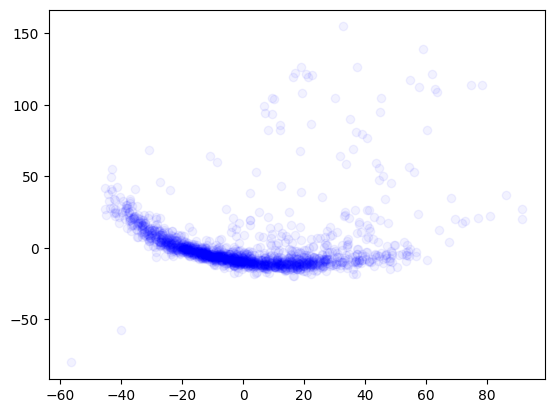

In [48]:
# inputs

pca = PCA()
principalComponents = pca.fit_transform(vae_input)
principalDf = pd.DataFrame(data = principalComponents)
plt.scatter(principalDf[[0]], principalDf[[1]], c='blue', alpha=0.05)
plt.show()

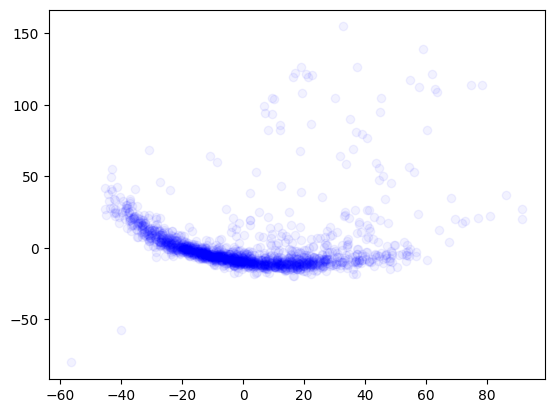

In [49]:
# outputs

output_for_pca = pd.DataFrame(vae_output).dropna(axis=1)
pca = PCA()
principalComponents = pca.fit_transform(output_for_pca)
principalDf = pd.DataFrame(data = principalComponents)
plt.scatter(principalDf[[0]], principalDf[[1]], c='blue', alpha=0.05)
plt.show()

In [12]:
vae = VAE(n_dim_i=vae_input.shape[1], n_dim_o = len(aniso_union), n_dim_latent=2, n_hidden_layers=[3, 6], n_hidden_size=100, activation="tanh")
vae.train(vae_input, vae_output, n_steps=4000, batchsize=100, lr=0.001, record_time=True, verbose=False)
loss_array = np.array(vae.loss_train)

2022-11-10 21:06:44.799205: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-11-10 21:06:44.830135: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:82:00.0 name: Tesla P100-PCIE-12GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 511.41GiB/s
2022-11-10 21:06:44.830183: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-11-10 21:06:44.866122: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-11-10 21:06:44.866247: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-11-10 21:06:44.882433: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuff

In [13]:
vae.save(f'../vae-optimization/latent-dim-2-nov9-4000.pkl')

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(vae_input, vae_output, test_size=0.1, random_state=42)

for latent_dim in range(9, 13, 2):
    print(f"Training w/ Latent Space of Dimension {latent_dim}")
    vae = NEW_VAE(n_dim_i=vae_input.shape[1], n_dim_o = len(aniso_union), n_dim_latent=latent_dim, n_hidden_layers=[3, 6], n_hidden_size=100, activation="tanh")
    vae.train(x_train, x_test, y_train, y_test, n_steps=4000, batchsize=100, lr=0.001, record_time=True, verbose=False, test_freq=100)
    train_loss_array, test_loss_array = np.array(vae.loss_train), np.array(vae.loss_test)
    
    vae.save(f'../vae-optimization/latent-dim-{latent_dim}-nov9-4000.pkl')

Training w/ Latent Space of Dimension 9


  0%|          | 0/4000 [00:00<?, ?it/s]

0


In [69]:
vae = VAE.load('../vae-optimization/latent-dim-3-aug23-4000.pkl')
loss_array = np.array(vae.loss_train)

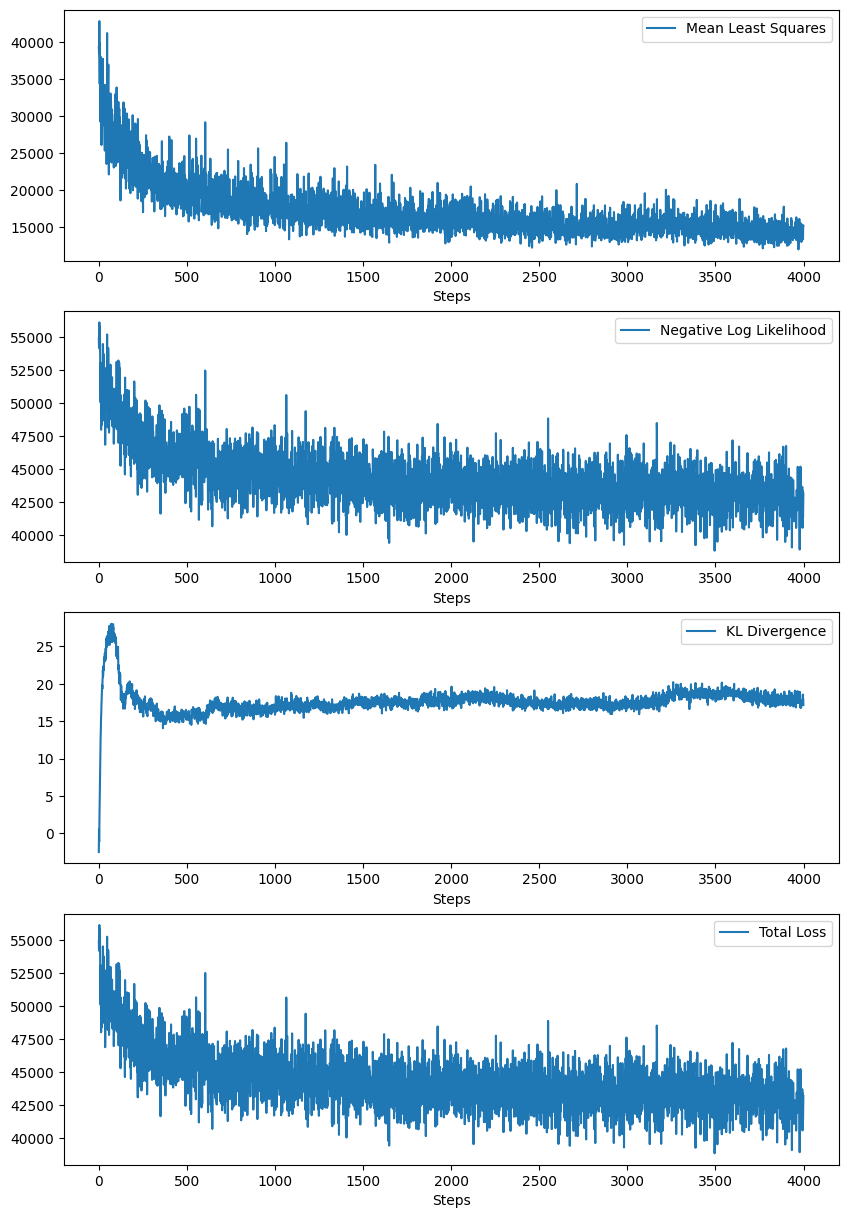

In [71]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=[10,15])
ax = axs.reshape(-1)

ax[0].plot(loss_array[:,3], label='Mean Least Squares')
ax[0].set_xlabel("Steps")
ax[0].legend()

ax[1].plot(loss_array[:,1], label='Negative Log Likelihood')
ax[1].set_xlabel("Steps")
ax[1].legend()

ax[2].plot(loss_array[:,2], label='KL Divergence')
ax[2].set_xlabel("Steps")
ax[2].legend()

ax[3].plot(loss_array[:,0], label='Total Loss')
ax[3].set_xlabel("Steps")
ax[3].legend()

plt.show()

### Reconstruction

In [9]:
vae = VAE.load('../vae-optimization/latent-dim-3-aug23-4000.pkl')

2022-11-11 08:52:18.806646: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-11-11 08:52:18.875640: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:1a:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-11-11 08:52:18.875712: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-11-11 08:52:18.891566: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-11-11 08:52:18.891667: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-11-11 08:52:18.902568: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library li

#### Single File

In [19]:
intersection = rs.read_mtz(f'../PTP1B_DK/oxidation_states/intersection.mtz')[['F-obs-oxidation']]

In [20]:
intersection = intersection.T
intersection = (intersection - vae_output_mean[intersection.columns])/vae_output_std[intersection.columns]

In [30]:
z_mean, z_log_var, z = vae.encoder(np.array(intersection).astype(np.float32))
recons = vae.decoder(z)
recons = recons.numpy()

In [35]:
original_ds = rs.read_mtz(f'../PTP1B_DK/oxidation_states/scaled_OxidationData_1EOS_Apo_DiffMap.mtz')

In [43]:
original_ds = original_ds.merge(aniso_union, left_index=True, right_index=True)

In [44]:
original_ds

F-obs  SIGF-obs  R-free-flags  F-obs-filtered  SIGF-obs-filtered  \
H  K L                                                                       
0  0  6   134.2     2.383             0        2335.619           41.47377   
      9   84.87     1.503             0        1477.079          26.158237   
      12   55.4    0.9909             0       964.18256           17.24564   
      15  71.83     1.283             0       1250.1305          22.329353   
      18  71.04     1.271             0       1236.3813          22.120506   
...         ...       ...           ...             ...                ...   
48 3  6     NaN       NaN           NaN             NaN                NaN   
49 0 -12    NaN       NaN           NaN             NaN                NaN   
      12    NaN       NaN           NaN             NaN                NaN   
   1 -7     NaN       NaN           NaN             NaN                NaN   
      7     NaN       NaN           NaN             NaN                NaN   

           F-model    PHIF-model    2FOFCWT  PH2FOFCWT  2FOFCWT_no_fill  ...  \
H  K L                                                                   ...   
0  0  6   2449.879        -180.0  1500.5835      180.0        1500.5835  ...   
      9  1968.0516           0.0  1061.5844        0.0        1061.5844  ...   
      12  683.6439  3.095863e-14  670.49426        0.0        670.49426  ...   
      15 1440.3878           0.0   910.5498        0.0         910.5498  ...   
      18 1155.9259 1.5668616e-15  874.21594        0.0        874.21594  ...   
...            ...           ...        ...        ...              ...  ...   
48 3  6        NaN           NaN  17.342167  154.04353              NaN  ...   
49 0 -12       NaN           NaN  39.593994      180.0              NaN  ...   
      12       NaN           NaN 0.18183918        0.0              NaN  ...   
   1 -7        NaN           NaN   10.19718 -51.984882              NaN  ...   
      7        NaN           NaN  23.828632 -64.720795              NaN  ...   

          F-obs-scaled_1955  F-obs-scaled_1956  F-obs-scaled_1957  \
H  K L                                                              
0  0  6           146.35599           149.2227          156.18695   
      9           85.536385           90.14671           80.00077   
      12          55.642406           53.90476          61.445896   
      15           71.69722           69.17753          74.636955   
      18          74.646515          74.800186            78.5226   
...                     ...                ...                ...   
48 3  6                 NaN                NaN          1.1391643   
49 0 -12                NaN                NaN          1.9803587   
      12                NaN                NaN          1.4949898   
   1 -7                 NaN                NaN           1.308683   
      7                 NaN                NaN          1.2243775   

          F-obs-scaled_1958  F-obs-scaled_1959  F-obs-scaled_1960  \
H  K L                                                              
0  0  6           176.00505           161.1973          152.81723   
      9             74.9272          79.857376            79.7532   
      12          62.088024          58.007286          57.250774   
      15           81.86619          72.029495           67.21158   
      18            80.2505             71.277          69.976814   
...                     ...                ...                ...   
48 3  6                 NaN                NaN          1.0958115   
49 0 -12                NaN                NaN          1.6867577   
      12                NaN                NaN          1.5259843   
   1 -7                 NaN                NaN          1.3500652   
      7                 NaN                NaN          1.8461417   

          F-obs-scaled_1962  F-obs-scaled_1963  F-obs-scaled_1964  \
H  K L                                                              
0  0  6             

In [67]:
recons_df = pd.DataFrame(recons.T, index=aniso_union.index, columns=['recons_oxidation'])

In [74]:
idx = original_ds.index

recons_col = recons_df['recons_oxidation'][idx] * vae_output_std[idx] + vae_output_mean[idx]
recons_col = rs.DataSeries(recons_col, dtype="SFAmplitude")

In [75]:
original_ds['F-obs-recons'] = recons_col

/n/home10/phyllis/mambaforge/envs/rs/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """Entry point for launching an IPython kernel.


In [76]:
original_ds['F-obs-diff'] = original_ds['F-obs-scaled'] - original_ds['F-obs-recons']

/n/home10/phyllis/mambaforge/envs/rs/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """Entry point for launching an IPython kernel.


In [78]:
original_ds.write_mtz(f'../PTP1B_DK/oxidation_states/recons_OxidationData_1EOS_Apo_DiffMap.mtz')

/n/home10/phyllis/mambaforge/envs/rs/lib/python3.7/site-packages/reciprocalspaceship/dataset.py:327: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  col_fill=col_fill,


#### Original Samples

In [15]:
z_mean, z_log_var, z = vae.encoder(vae_input)
recons = vae.decoder(z)
recons = recons.numpy()

recons_df = pd.DataFrame(recons.T, index=aniso_union.index, columns=aniso_union.columns)
z_mean_df = pd.DataFrame(np.array(z_mean).T, columns=aniso_union.columns)
z_log_var_df = pd.DataFrame(np.array(z_log_var).T, columns=aniso_union.columns)

In [16]:
for sample in samples:
    
    try:
        col = recons_df[f'F-obs-scaled_{sample}']
        
    except: 
        continue

    # add reconstructed column
    ds = rs.read_mtz(f'../PTP1B_DK/scaled_vector_mtzs/PTP1B-y{sample}_mrflagsref_idxs_scaled.mtz')
    idx = ds.index

    recons_col = col[idx] * vae_output_std[idx] + vae_output_mean[idx]
    recons_col = rs.DataSeries(recons_col, dtype="SFAmplitude")

    ds['F-obs-recons'] = recons_col

    ds['F-obs-diff'] = ds['F-obs-scaled'] - ds['F-obs-recons']

    # add standard deviation column
#     latent_space_sampling = tf.random.normal([10000, 3], mean=z_mean_df[f'F-obs-scaled_{sample}'], stddev=np.sqrt(np.exp(z_log_var_df[f'F-obs-scaled_{sample}'])))
#     recons_samples = vae.decoder(latent_space_sampling).numpy()

#     for i in range(len(recons_samples)):
#         recons_samples[i] = recons_samples[i] * vae_output_std + vae_output_mean

#     recons_sig_F = np.std(recons_samples, axis=0)
#     recons_sig_F_df = pd.DataFrame(recons_sig_F.T, index=aniso_union.index, columns=['SIGF-recons'])

#     ds['SIGF-recons'] = rs.DataSeries(recons_sig_F_df['SIGF-recons'][idx], dtype="Stddev")

    ds.write_mtz(f'../PTP1B_DK/recons_mtzs_2/PTP1B-y{sample}_mrflagsref_idxs_recons.mtz')

In [16]:
z_mean, z_log_var, z = vae.encoder(vae_input)
recons = vae.decoder(z)
recons = recons.numpy()

In [17]:
yrecons_intersection = recons[:, ~(np.isnan(vae_output).any(axis=0))]
yrecons_intersection = yrecons_intersection * np.tile(vae_output_std[aniso_intersection.index].values, (1630, 1)) + np.tile(vae_output_mean[aniso_intersection.index].values, (1630, 1))

ValueError: operands could not be broadcast together with shapes (1680,2104) (1630,2104) 

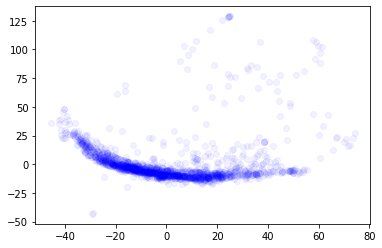

In [22]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(yrecons_intersection)
plt.scatter(principalComponents[:,0], principalComponents[:,1], c='blue', alpha=0.05)
plt.show()

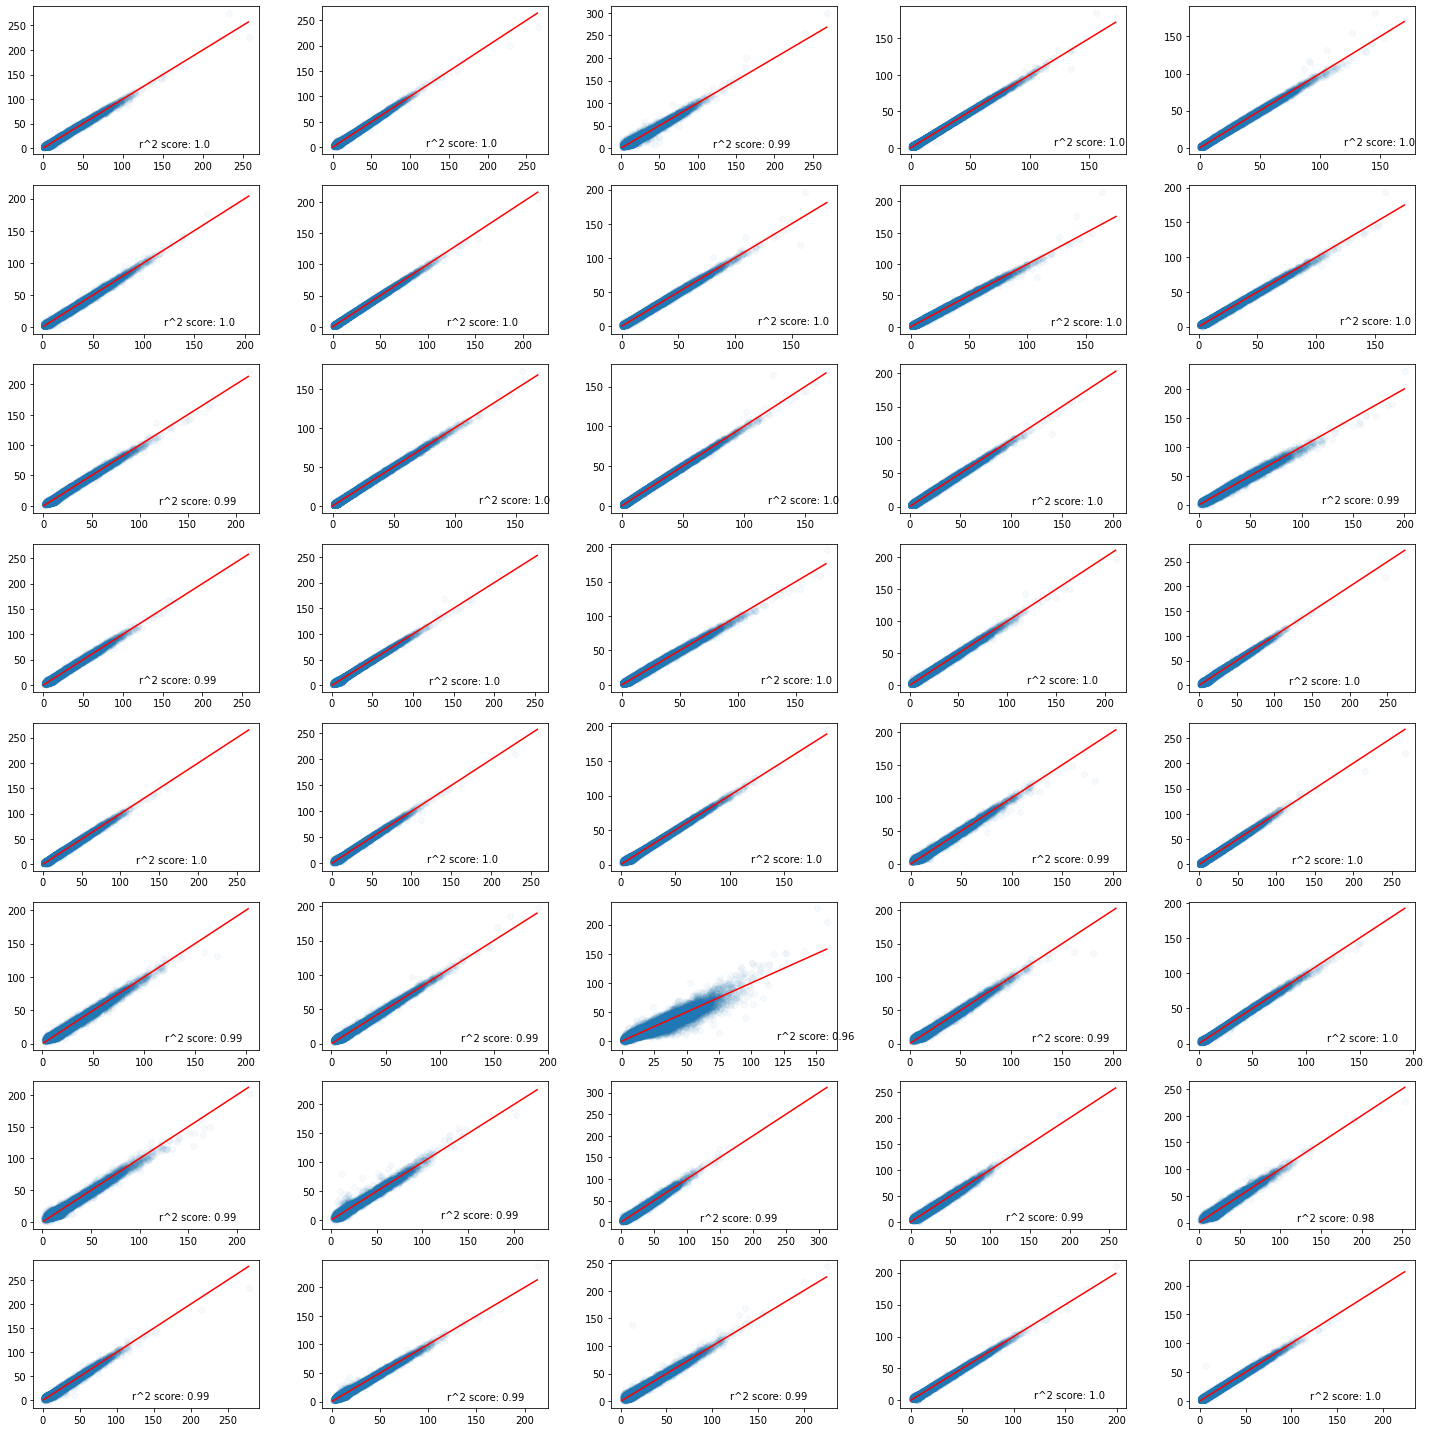

In [18]:
fig, ax = plt.subplots(8, 5, figsize=(20, 20))

loc = 0
for i in samples[1:]:
        
    if loc > 39:
        break 
        
    try: 
        current = rs.read_mtz(f'../PTP1B_DK/recons_mtzs/PTP1B-y{i}_mrflagsref_idxs_recons.mtz')
        
    except:
        continue
                
    r2 = stats.pearsonr(current['F-obs-scaled'], current['F-obs-recons'])
        
    ax[loc // 5][loc % 5].scatter(current['F-obs-scaled'], current['F-obs-recons'], alpha=0.03)
    
    min_ = np.floor(min(current['F-obs-scaled']))
    max_ = np.ceil(max(current['F-obs-scaled']))
    
    ax[loc // 5][loc % 5].plot(np.arange(min_, max_), np.arange(min_, max_), c='red')
    ax[loc // 5][loc % 5].text(120, 3, f'r^2 score: {round(r2[0], 2)}')

    loc += 1
    
plt.tight_layout()
plt.show()

In [19]:
data = {}

for i in samples[1:]:
        
    try: 
        current = rs.read_mtz(f'../PTP1B_DK/recons_mtzs/PTP1B-y{i}_mrflagsref_idxs_recons.mtz')
        
    except:
        continue
    
    data[i] = {}
    data[i]['mse'] = np.mean((current['F-obs-scaled'] - current['F-obs-recons'])**2)
    data[i]['corr'] = stats.pearsonr(current['F-obs-scaled'], current['F-obs-recons'])[0]

(array([1.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 6.000e+00, 3.000e+00,
        1.500e+01, 4.000e+01, 7.000e+01, 1.541e+03]),
 array([0.36767096, 0.43083139, 0.49399181, 0.55715224, 0.62031267,
        0.6834731 , 0.74663353, 0.80979396, 0.87295439, 0.93611482,
        0.99927525]),
 <BarContainer object of 10 artists>)

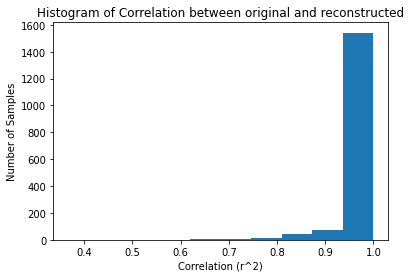

In [20]:
plt.title("Histogram of Correlation between original and reconstructed")
plt.xlabel("Correlation (r^2)")
plt.ylabel("Number of Samples")
plt.hist([data[x]["corr"] for x in data])

(array([1.598e+03, 5.500e+01, 1.500e+01, 4.000e+00, 4.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([2.60385374e-01, 1.09993379e+02, 2.19726373e+02, 3.29459367e+02,
        4.39192361e+02, 5.48925355e+02, 6.58658348e+02, 7.68391342e+02,
        8.78124336e+02, 9.87857330e+02, 1.09759032e+03]),
 <BarContainer object of 10 artists>)

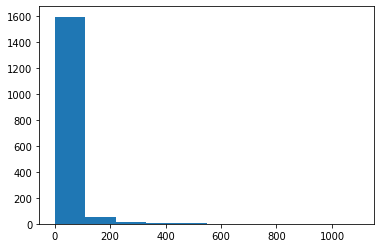

In [21]:
plt.hist([data[x]["mse"] for x in data])

In [49]:
# VAE: low correlation (i.e. less than 0.5): 0162, 0429, 0494, 0497, 0999, 1116, 1377, 1912
# VAE: high MSE (i.e. greater than 700): 0162, 0413, 0429, 0494, 0497, 0999, 1116, 1377, 1463, 1529
# Not correlated with low scaling correlation

##### Fully Reconstructed Model (Refinement)

In [83]:
# generate fully reconstructed model for refinement

for x in range(len(aniso_intersection.columns)):
    if (aniso_intersection.columns[x] == 'F-obs-scaled_1288'):
        print(x)
        
recons[1066]

check = pd.DataFrame(recons[1066], index=aniso_union.index)
check[0] = check[0] * vae_output_std[aniso_union.index] + vae_output_mean[aniso_union.index]

ds = rs.read_mtz(f'../PTP1B_DK/scaled_vector_mtzs_reindex/PTP1B-y1288_mrflagsref_idxs_scaled.mtz')
for x in ds.columns:
    del ds[x]
    
ds.index = aniso_union.index
ds

recons_col = rs.DataSeries(check[0], dtype="SFAmplitude")

ds['F-obs-recons_1288'] = recons_col
ds

other = rs.read_mtz(f'../PTP1B_DK/scaled_vector_mtzs_reindex/PTP1B-y1288_mrflagsref_idxs_scaled.mtz')
other
ds['SIGF-obs'] = other['SIGF-obs']

ds.write_mtz(f'../PTP1B_DK/refinement/PTP1B-y1288_mrflagsref_idxs_fully_recons.mtz')

desired_row = np.array(ds.loc[aniso_intersection.index]['F-obs-recons_1288'])
original = np.array(aniso_intersection['F-obs-scaled_1288'])
pearsonr(desired_row, original)


'\n\nfor x in range(len(aniso_intersection.columns)):\n    if (aniso_intersection.columns[x] == \'F-obs-scaled_1288\'):\n        print(x)\n        \nrecons[1066]\n\ncheck = pd.DataFrame(recons[1066], index=aniso_union.index)\ncheck[0] = check[0] * vae_output_std[aniso_union.index] + vae_output_mean[aniso_union.index]\n\nds = rs.read_mtz(f\'PTP1B_DK/scaled_vector_mtzs_reindex/PTP1B-y1288_mrflagsref_idxs_scaled.mtz\')\nfor x in ds.columns:\n    del ds[x]\n    \nds.index = aniso_union.index\nds\n\nrecons_col = rs.DataSeries(check[0], dtype="SFAmplitude")\n\nds[\'F-obs-recons_1288\'] = recons_col\nds\nds.write_mtz(f\'./PTP1B_DK/refinement/PTP1B-y1288_mrflagsref_idxs_fully_recons.mtz\')\n\ndesired_row = np.array(ds.loc[aniso_intersection.index][\'F-obs-recons_1288\'])\noriginal = np.array(aniso_intersection[\'F-obs-scaled_1288\'])\npearsonr(desired_row, original)\n'

### PCA

In [23]:
# write to a file for the intersections of all files
F1 = rs.read_mtz(f'../PTP1B_DK/recons_mtzs/PTP1B-y0001_mrflagsref_idxs_recons.mtz')[['F-obs-recons']]
F1 = F1.rename(columns={'F-obs-recons': 'F-obs-recons_0001'})
for i in samples[1:]:
        
    try: 
        F2 = rs.read_mtz(f'../PTP1B_DK/recons_mtzs/PTP1B-y{i}_mrflagsref_idxs_recons.mtz')[['F-obs-recons']]
        F2 = F2.rename(columns={'F-obs-recons': f'F-obs-recons_{i}'})
        
    except:
        continue
                
    F1 = F1.merge(F2, left_index=True, right_index=True, check_isomorphous=False)
    
F1.write_mtz(f'../PTP1B_DK/recons_mtzs/intersection.mtz')

/n/home10/phyllis/mambaforge/envs/rs/lib/python3.7/site-packages/reciprocalspaceship/dataset.py:287: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  col_fill=col_fill,


In [24]:
# write to a file for the intersections of all files
F1 = rs.read_mtz(f'../PTP1B_DK/recons_mtzs/PTP1B-y0001_mrflagsref_idxs_recons.mtz')[['F-obs-diff']]
F1 = F1.rename(columns={'F-obs-diff': 'F-obs-diff_0001'})
for i in samples[1:]:
        
    try: 
        F2 = rs.read_mtz(f'../PTP1B_DK/recons_mtzs/PTP1B-y{i}_mrflagsref_idxs_recons.mtz')[['F-obs-diff']]
        F2 = F2.rename(columns={'F-obs-diff': f'F-obs-diff_{i}'})
        
    except:
        continue
                
    F1 = F1.merge(F2, left_index=True, right_index=True, check_isomorphous=False)
    
F1.write_mtz(f'../PTP1B_DK/recons_mtzs/difference_intersection.mtz')

In [25]:
recons_intersection = rs.read_mtz(f'../PTP1B_DK/recons_mtzs/difference_intersection.mtz')

/n/home10/phyllis/mambaforge/envs/rs/lib/python3.7/site-packages/reciprocalspaceship/io/mtz.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[c.label] = c.array


In [26]:
pca = PCA()
principalComponents = pca.fit_transform(recons_intersection.T)
principalDf = pd.DataFrame(data = principalComponents)
principalDf.index = recons_intersection.T.index

/n/home10/phyllis/mambaforge/envs/rs/lib/python3.7/site-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


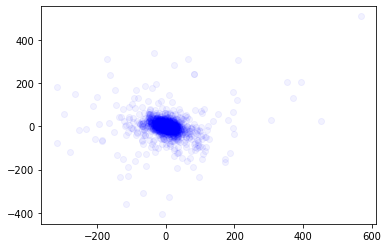

In [27]:
plt.scatter(principalComponents[:,0], principalComponents[:,1], c='blue', alpha=0.05)

In [28]:
principalDf

,0,1,2,3,4,5,6,7,8,9,...,1670,1671,1672,1673,1674,1675,1676,1677,1678,1679
F-obs-diff_0001,-13.065018,29.566525,-3.480581,7.957848,-0.039733,-0.804472,-5.653926,-1.479836,-5.152991,0.722489,...,-0.020985,-0.049087,-0.037996,0.071133,-0.024194,0.047746,-0.046078,-0.061299,-0.032553,2.007842e-15
F-obs-diff_0002,-1.486243,40.097818,-0.958911,29.899119,2.406092,25.323175,0.495980,7.682720,-9.933879,2.174416,...,-0.006926,-0.018741,0.043851,-0.032814,-0.003721,-0.008156,-0.028200,0.019968,-0.045108,2.007842e-15
F-obs-diff_0003,14.124398,-1.629912,-4.465467,-11.860599,7.185479,-2.982597,4.401221,-10.189813,1.369324,-4.392267,...,0.052770,-0.005726,-0.054068,-0.036982,-0.008901,-0.023816,0.017624,0.021287,0.000275,2.007842e-15
F-obs-diff_0004,8.156961,-35.663397,12.431164,6.518846,-6.173174,-25.640117,13.236850,-9.651597,-0.248874,6.925359,...,-0.007372,0.019822,-0.011836,0.005580,0.000035,0.011570,-0.011107,0.027100,0.000448,2.007842e-15
F-obs-diff_0006,6.166364,16.687854,4.508324,-12.220325,3.504315,7.265739,-10.661732,0.510490,0.783399,-6.708852,...,0.040437,-0.071700,-0.045823,-0.015664,-0.011822,0.051306,0.003641,-0.048919,-0.006182,2.007842e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F-obs-diff_1960,-24.027853,5.792102,5.095601,16.368020,-6.949786,-4.930039,-8.573064,8.343447,-3.313271,10.571150,...,0.173552,0.041648,-0.012891,-0.055055,0.013090,-0.046472,0.080461,-0.022306,-0.063125,2.007842e-15
F-obs-diff_1962,-11.499127,7.631291,7.246524,4.660442,-2.423357,6.823482,-3.995741,2.747620,-5.648439,4.250230,...,-0.028353,-0.001550,-0.018613,-0.025175,-0.049442,-0.021360,-0.052586,0.004476,-0.043176,2.007842e-15
F-obs-diff_1963,18.689177,12.023474,3.289233,-22.586085,0.984481,5.295120,-11.984647,10.830456,-5.339090,1.053534,...,0.030471,-0.009704,0.019949,0.039097,0.083771,0.005533,0.059211,0.133806,-0.006553,2.007842e-15
F-obs-diff_1964,208.245841,122.004207,-33.616636,-10.706674,32.352655,-10.559786,13.911032,-68.420164,-42.933066,-44.602942,...,0.041357,0.053659,-0.051814,-0.005382,-0.031314,0.033118,-0.041932,0.012893,-0.025676,2.007842e-15


### Reindex Info

In [102]:
set1 = set([x[-4:] for x in list(principalDf[principalDf[0] < 0].index)])
set2 = set([x[-4:] for x in list(principalDf[principalDf[0] > 0].index)])

In [104]:
reindex = json.load(open('reindex.json', "r"))

In [89]:
reindex_set1 = set()
reindex_set2 = set()
for x in reindex:
    if reindex[x] == 0:
        reindex_set1.add(x)
    else:
        reindex_set2.add(x)
reindex_set1.add('0001')

In [108]:
print("original", len(reindex_set1))
print("reconstructed", len(set1))
print("difference", len(set1.difference(reindex_set1)))

original 834
reconstructed 811
difference 0


In [109]:
print("original", len(reindex_set2))
print("reconstructed", len(set2))
print("difference", len(set2.difference(reindex_set2)))

original 846
reconstructed 819
difference 0


### Plot Variance

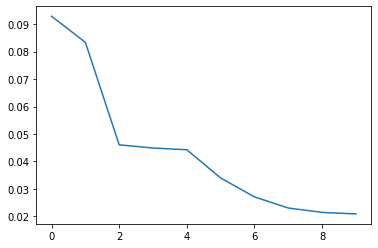

In [30]:
plt.plot(pca.explained_variance_ratio_[:10])

In [31]:
recons_intersection = rs.read_mtz('../PTP1B_DK/recons_mtzs/intersection.mtz')
recons_intersection = recons_intersection.T
Xrmean = recons_intersection.mean(axis=0)
Xrmeanfree = recons_intersection - Xrmean
Cr = np.dot(Xrmeanfree.T, Xrmeanfree) / (Xrmeanfree.shape[0] - 1.0)
Cr = np.array(Cr, dtype=float)
vr = np.linalg.eigvals(Cr)
v2r = np.sort(vr**2)[::-1]
eigfractionr = np.cumsum(v2r)/np.sum(v2r)

/n/home10/phyllis/mambaforge/envs/rs/lib/python3.7/site-packages/reciprocalspaceship/io/mtz.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[c.label] = c.array


/n/home10/phyllis/mambaforge/envs/rs/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


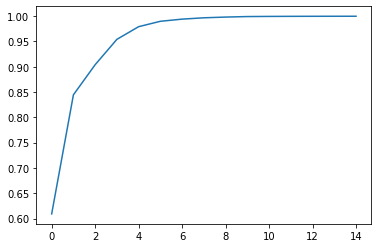

In [32]:
plt.plot(eigfractionr[:15])

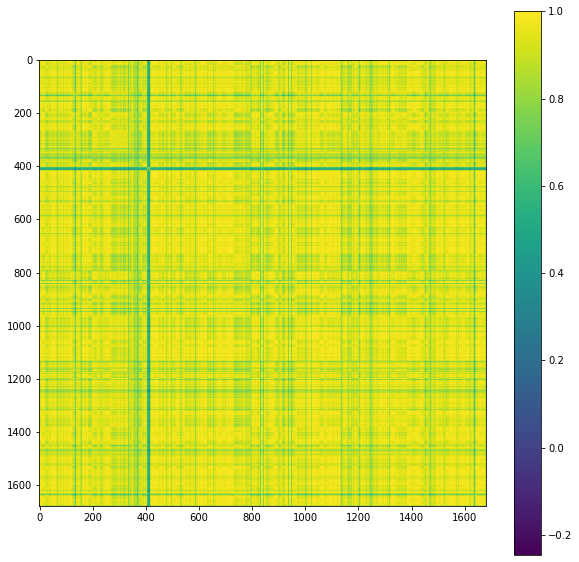

In [33]:
plt.figure(figsize=(10, 10))
plt.imshow(recons_intersection.T.corr().to_numpy())
plt.colorbar()
plt.show()